In [1]:
import json
import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC, SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans

In [34]:
#GLOBALS
divs = ['NEW', 'NOV', 'INT', 'ADV', 'ALS', 'ALS+']
divs_set = set(divs)
divs_set_starter = set(['NEW', 'NOV'])
jr_key = 'JRS'
keys_map_basic = {
    'NEW':'Newcomer', 'NOV':'Novice', 'INT':'Intermediate', 'ADV':'Advanced', 'ALS':'Allstar', 'ALS+':'Champion'
}
key_map = {
    'NEW-NOV': 'Newcomer/Novice', 
    'NOV-NOV': 'Novice', 
    'NOV-INT': 'Novice/Intermediate', 
    'INT-INT': 'Intermediate', 
    'INT-ADV': 'Intermediate/Advanced', 
    'ADV-ADV': 'Advanced',  
    'ADV-ALS': 'Advanced/Allstar',  
    'ALS-ALS': 'Allstar', 
    'ALS-ALS+': 'Allstar/Champion', 
    'ALS+-ALS+': 'Champion'}
min_dt = datetime.datetime(1900, 1, 1)
max_dt = datetime.datetime(2100, 1, 1)
max_year = 2021
min_year = 2010
first_point_year = 2015

In [57]:
def load():
    with open('../data/regPoints_full.json') as f:
        data = json.load(f)
    keys = list(data.keys())
    # Transform data
    for key in keys:
        competitor = data[key]
        # Filter People Without Placements
        if len(competitor['placements']) == 0 or 'West Coast Swing' not in competitor['placements']:
            del data[key]
            continue
        # Filter People Without Placements in Major Categories
        if len([key for key in competitor['placements']['West Coast Swing'].keys() if key in divs_set]) == 0:
            del data[key]
            continue
        # Filter People Without Placements in Starter Categories
        if len([key for key in competitor['placements']['West Coast Swing'].keys() if key in divs_set_starter]) == 0:
            del data[key]
            continue
        # Transform
        competitor['first_comp'] = get_first_comp(competitor)
        competitor['role'] = get_main_role(competitor)
        competitor[jr_key] = get_first_div_comp(competitor, jr_key)
        for div in divs:
            competitor[div] = get_first_div_comp(competitor, div)
        for i in range(len(divs)-1):            
            set_div_delta(competitor, divs[i], divs[i+1])
    keys = list(data.keys())
    return data, keys

In [58]:
def get_first_comp(competitor):
    ret = datetime.datetime(2021, 1, 1)
    if len(competitor['placements']) == 0 or 'West Coast Swing' not in competitor['placements']:
        return min_dt
    for division in competitor['placements']['West Coast Swing']: 
        for comp in competitor['placements']['West Coast Swing'][division]['competitions']:
            comp_date = comp['event']['date']
            comp_date = datetime.datetime.strptime(comp_date, '%B %Y')
            if ret > comp_date:
                ret = comp_date
    return ret

In [59]:
def get_main_role(competitor): #we might want to extend this later
    lc = 0
    fc = 0
    if len(competitor['placements']) == 0 or 'West Coast Swing' not in competitor['placements']:
        return 'fleader'
    for division in competitor['placements']['West Coast Swing']: 
        for comp in competitor['placements']['West Coast Swing'][division]['competitions']:
            role = comp['role']
            if role == 'leader':
                lc+=1
            else:
                fc+=1
    if lc > fc:
        return 'leader'
    else:
        return 'follower'
    return ret

In [5]:
def get_first_div_comp(competitor, division):
    ret = max_dt
    if len(competitor['placements']) == 0 or 'West Coast Swing' not in competitor['placements']:
        return min_dt
    if not division in competitor['placements']['West Coast Swing']:
        return max_dt
    for comp in competitor['placements']['West Coast Swing'][division]['competitions']:
        comp_date = comp['event']['date']
        comp_date = datetime.datetime.strptime(comp_date, '%B %Y')
        if ret > comp_date:
            ret = comp_date
    return ret

In [6]:
def set_div_delta(competitor, source, target):
    s = competitor[source]
    t = competitor[target]
    diff = (t - s).days / 365
    if diff < 0:
        diff = 0 # This should only happen with New->Nov
    if diff == 0: # They actually didn't level up
        diff = 100 # 100 Years From Now...
    competitor[f'{source}->{target}'] = diff

In [7]:
def print_count_stats(year):
    level_count = {}
    ret = []
    for key in keys:
        level = get_composite_level(data[key])
        if not level in level_count:
            level_count[level] = 0
        if data[key]['first_comp'] >= datetime.datetime(year, 1, 1):
            level_count[level] += 1
            ret.append(key)
    t = np.sum(list(level_count.values()))
    print(f'For WCS Competitors (Total: {t}) who got their first point after Jan 1 {year}, we have:')
    for key in key_map:
        if key in level_count:
            percent = str(int(round((level_count[key] / t) * 100))).rjust(2, ' ')
            total = str(level_count[key]).rjust(4, ' ')
            print(f'{percent}% {total} {key_map[key]}')
    print('')
    return ret, level_count

In [8]:
def print_count_stats_one_year(year):
    level_count = {}
    ret = []
    for key in keys:
        level = get_composite_level(data[key])
        if not level in level_count:
            level_count[level] = 0
        if data[key]['first_comp'] >= datetime.datetime(year, 1, 1) and data[key]['first_comp'] < datetime.datetime(year+1, 1, 1):
            level_count[level] += 1
            ret.append(key)
    t = np.sum(list(level_count.values()))
    print(f'For WCS Competitor (Total: {t}) who got their first point in {year}, we have:')
    for key in key_map:
        if key in level_count:
            percent = str(int(round((level_count[key] / t) * 100))).rjust(2, ' ')
            total = str(level_count[key]).rjust(4, ' ')
            print(f'{percent}% {total} {key_map[key]}')
    print('')
    return ret, level_count

In [9]:
def print_competitor(competitor):
    c = competitor['dancer']
    fname = c['first_name']
    lname = c['last_name']
    wcsid = c['wscid']
    print(f'({wcsid}) {fname} {lname}')

In [10]:
def get_composite_level(competitor):
    return competitor['level']['required'] + '-' + competitor['level']['allowed']

In [71]:
def filter_novice_starts(data, keys):
    # Filter out anyone who started in novice
    for key in keys:
        if data[key]['NEW'] == max_dt:
            del data[key]
            continue
    keys = list(data.keys())
    return data, keys 

def filter_newcomer_starts(data, keys):
    # Filter out anyone who started in newcomer
    for key in keys:
        if not data[key]['NEW'] == max_dt:
            del data[key]
            continue
    keys = list(data.keys())
    return data, keys 
def filter_new_dancers(data, keys, first_point_year):
    for key in keys:
        if data[key]['first_comp'] > datetime.datetime(first_point_year, 1, 1):
            del data[key]
            continue
    keys = list(data.keys())
    return data, keys 
def filter_nov_to_new(data, keys):
    for key in keys:
        if (data[key]['NOV'] - data[key]['NEW']).days < 0:
            del data[key]
            continue
    keys = list(data.keys())
    return data, keys 
def filter_out_non_jrs(data, keys):
    #Only people who started in JRs
    for key in keys:
        if data[key][jr_key] == max_dt:
            del data[key]
            continue
    keys = list(data.keys())
    return data, keys 
def filter_out_jrs(data, keys):
    #Only people who started in JRs
    for key in keys:
        if not data[key][jr_key] == max_dt:
            del data[key]
            continue
    keys = list(data.keys())
    return data, keys
def filter_out_leaders(data, keys):
    for key in keys:
        if data[key]['role'] == 'leader':
            del data[key]
            continue
    keys = list(data.keys())
    return data, keys
def filter_out_followers(data, keys):
    for key in keys:
        if data[key]['role'] == 'follower':
            del data[key]
            continue
    keys = list(data.keys())
    return data, keys

In [77]:
data, keys = load()

In [78]:
#data, keys = filter_newcomer_starts(data, keys)
data, keys = filter_new_dancers(data, keys, first_point_year)
#data, keys = filter_nov_to_new(data, keys)
#data, keys = filter_out_jrs(data, keys)
data, keys = filter_out_leaders(data, keys)
print(len(keys))

5299


In [79]:
# Sanity check
count_newcomer_start       = len([0 for key in keys if not data[key]['NEW'] == max_dt])
count_novice_start         = len([0 for key in keys if     data[key]['NEW'] == max_dt])
count_novice_start_check   = len([0 for key in keys if     data[key]['NEW'] == max_dt and not data[key]['NOV'] == max_dt])
count_novice               = len([0 for key in keys if not data[key]['NOV'] == max_dt])
if count_newcomer_start + count_novice_start == len(keys) and count_novice_start_check == count_novice_start:
    print('People must start in New/Nov Sanity Check: PASSED\n')
else:
    print('People must start in New/Nov Sanity Check FAILED\n')
print(f'Total Starting Novice: {count_novice_start}')
print(f'Total Starting Newcomer: {count_newcomer_start}')
print(f'Total Ever Newcomer: {count_newcomer_start}')
print(f'Total Ever Novice: {count_novice}')
print(f'Percentage Novice Started Newcomer {int(100 * (1 - count_novice_start/count_novice))}%')

People must start in New/Nov Sanity Check: PASSED

Total Starting Novice: 3212
Total Starting Newcomer: 2087
Total Ever Newcomer: 2087
Total Ever Novice: 4153
Percentage Novice Started Newcomer 22%


In [80]:
_ = print_count_stats(1900)#Follower stats

For WCS Competitors (Total: 5299) who got their first point after Jan 1 1900, we have:
21% 1118 Newcomer/Novice
31% 1656 Novice
 7%  379 Novice/Intermediate
19% 1007 Intermediate
 2%   94 Intermediate/Advanced
15%  779 Advanced
 1%   45 Advanced/Allstar
 3%  179 Allstar
 1%   42 Champion



In [75]:
_ = print_count_stats(1900)#Leader Stats

For WCS Competitors (Total: 4417) who got their first point after Jan 1 1900, we have:
19%  859 Newcomer/Novice
30% 1305 Novice
 8%  343 Novice/Intermediate
19%  840 Intermediate
 2%   83 Intermediate/Advanced
17%  734 Advanced
 1%   38 Advanced/Allstar
 4%  182 Allstar
 1%   33 Champion



In [18]:
# Count dancers by level
for year in range(min_year, max_year):
    print_count_stats(year)

For WCS Competitors (Total: 11862) who got their first point after Jan 1 2010, we have:
36% 4299 Newcomer/Novice
27% 3250 Novice
 9% 1114 Novice/Intermediate
15% 1769 Intermediate
 2%  226 Intermediate/Advanced
 7%  782 Advanced
 1%  103 Advanced/Allstar
 3%  308 Allstar
 0%   11 Champion

For WCS Competitors (Total: 11230) who got their first point after Jan 1 2011, we have:
37% 4136 Newcomer/Novice
28% 3114 Novice
10% 1068 Novice/Intermediate
15% 1649 Intermediate
 2%  207 Intermediate/Advanced
 6%  698 Advanced
 1%   96 Advanced/Allstar
 2%  257 Allstar
 0%    5 Champion

For WCS Competitors (Total: 10417) who got their first point after Jan 1 2012, we have:
37% 3906 Newcomer/Novice
28% 2927 Novice
 9%  987 Novice/Intermediate
15% 1517 Intermediate
 2%  186 Intermediate/Advanced
 6%  598 Advanced
 1%   78 Advanced/Allstar
 2%  214 Allstar
 0%    4 Champion

For WCS Competitors (Total: 9492) who got their first point after Jan 1 2013, we have:
39% 3694 Newcomer/Novice
28% 2703 Novice

In [19]:
# Count dancers by level
for year in range(min_year, max_year):
    print_count_stats_one_year(year)

For WCS Competitor (Total: 632) who got their first point in 2010, we have:
26%  163 Newcomer/Novice
22%  136 Novice
 7%   46 Novice/Intermediate
19%  120 Intermediate
 3%   19 Intermediate/Advanced
13%   84 Advanced
 1%    7 Advanced/Allstar
 8%   51 Allstar
 1%    6 Champion

For WCS Competitor (Total: 813) who got their first point in 2011, we have:
28%  230 Newcomer/Novice
23%  187 Novice
10%   81 Novice/Intermediate
16%  132 Intermediate
 3%   21 Intermediate/Advanced
12%  100 Advanced
 2%   18 Advanced/Allstar
 5%   43 Allstar
 0%    1 Champion

For WCS Competitor (Total: 925) who got their first point in 2012, we have:
23%  212 Newcomer/Novice
24%  224 Novice
11%  100 Novice/Intermediate
19%  176 Intermediate
 2%   22 Intermediate/Advanced
13%  120 Advanced
 1%   12 Advanced/Allstar
 6%   57 Allstar
 0%    2 Champion

For WCS Competitor (Total: 1020) who got their first point in 2013, we have:
29%  293 Newcomer/Novice
24%  243 Novice
 9%   95 Novice/Intermediate
19%  193 Interme

In [20]:
# Who grew quickly recently?
year = 2017
competitors, _ = print_count_stats(year)
for composite in ['ALS-ALS', 'ADV-ALS']:
    print(f'Competitors reaching {key_map[composite]} since Jan {year}')
    for competitor in competitors:
        if get_composite_level(data[competitor]) == composite:
            print_competitor(data[competitor])
    print('')

For WCS Competitors (Total: 4437) who got their first point after Jan 1 2017, we have:
46% 2027 Newcomer/Novice
33% 1444 Novice
 8%  367 Novice/Intermediate
10%  456 Intermediate
 1%   36 Intermediate/Advanced
 2%   85 Advanced
 0%   10 Advanced/Allstar
 0%   12 Allstar
 0%    0 Champion

Competitors reaching Allstar since Jan 2017
(15296) Kathleen Sun
(15300) Deon Harrell
(15378) Raisa Khismatullina
(15581) Attila Kobori
(15656) Tuan Nguyen
(16071) Emily J. Huang
(16096) Elizabeth Ferreira
(16222) Tim Kenny
(16285) Melodie Paletta
(16370) Samantha Boice
(16485) Omar Gonzalez
(17980) Jt Anderson

Competitors reaching Advanced/Allstar since Jan 2017
(15530) Alexandra Branco
(15606) Dimitri Hector
(15684) Christian Kaller
(15713) Clement Turpain
(15837) Charlotte Zell
(15928) Florian Simon
(16097) Laurel Walker
(16270) Stephen Freeman
(16854) Gabi Wasserman
(16905) Alec Grant



In [21]:
print('For people who reach these levels:\n')
def diff_inds(key, i, j):
    return (data[key][divs[j]] - data[key][divs[i]]).days / 365
top = len(divs)-1
for i in range(top):
    for j in range(i+1, top):
        s_str = keys_map_basic[divs[i]].ljust(13, ' ')
        t_str = keys_map_basic[divs[j]].ljust(13, ' ')
        valids = [diff_inds(key, i, j) for key in keys if diff_inds(key, i, j) < 50 and diff_inds(key, i, j) > 0]
        avg = np.mean(valids)
        print(f'{avg:.3f} mean years from first points in {s_str} -> {t_str}')        

For people who reach these levels:

1.422 mean years from first points in Newcomer      -> Novice       
2.611 mean years from first points in Newcomer      -> Intermediate 
3.656 mean years from first points in Newcomer      -> Advanced     
5.018 mean years from first points in Newcomer      -> Allstar      
1.834 mean years from first points in Novice        -> Intermediate 
3.103 mean years from first points in Novice        -> Advanced     
5.061 mean years from first points in Novice        -> Allstar      
1.988 mean years from first points in Intermediate  -> Advanced     
3.879 mean years from first points in Intermediate  -> Allstar      
2.888 mean years from first points in Advanced      -> Allstar      


In [22]:
print('For people who reach these levels:\n')
def diff_inds(key, i, j):
    return (data[key][divs[j]] - data[key][divs[i]]).days / 365
top = len(divs)-1
for i in range(top):
    for j in range(i+1, top):
        s_str = keys_map_basic[divs[i]].ljust(13, ' ')
        t_str = keys_map_basic[divs[j]].ljust(13, ' ')
        valids = [diff_inds(key, i, j) for key in keys if diff_inds(key, i, j) < 50 and diff_inds(key, i, j) > 0]
        med = np.median(valids)
        print(f'{med:.3f} median years from first points in {s_str} -> {t_str}')        

For people who reach these levels:

1.000 median years from first points in Newcomer      -> Novice       
2.167 median years from first points in Newcomer      -> Intermediate 
3.088 median years from first points in Newcomer      -> Advanced     
4.668 median years from first points in Newcomer      -> Allstar      
1.337 median years from first points in Novice        -> Intermediate 
2.584 median years from first points in Novice        -> Advanced     
4.422 median years from first points in Novice        -> Allstar      
1.504 median years from first points in Intermediate  -> Advanced     
3.337 median years from first points in Intermediate  -> Allstar      
2.164 median years from first points in Advanced      -> Allstar      


In [23]:
# Counts in each div
print(f'Total people: {len(keys)}')
print('Total number of people with a point in the following divs:\n')
count_with_points = {}
for i in range(len(divs)-1):
    count = len([0 for key in keys if data[key][divs[i]] > min_dt and data[key][divs[i]] < max_dt])
    count_with_points[divs[i]] = count
    justified = keys_map_basic[divs[i]].ljust(12, ' ')
    print(f'{justified}: {count}')

Total people: 16746
Total number of people with a point in the following divs:

Newcomer    : 8128
Novice      : 11767
Intermediate: 5149
Advanced    : 2357
Allstar     : 761


For people who reach these levels:



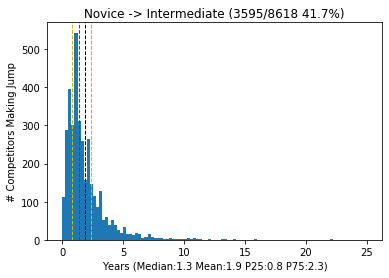

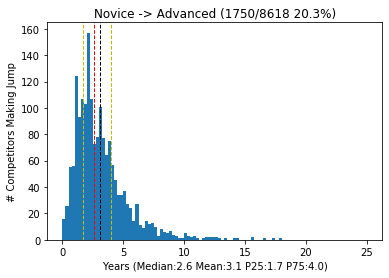

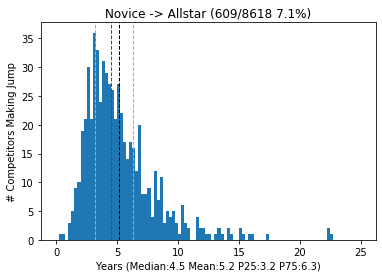

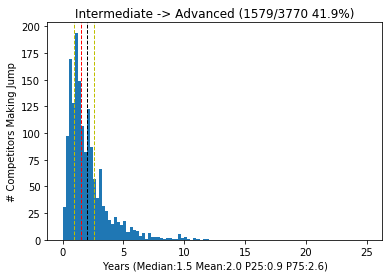

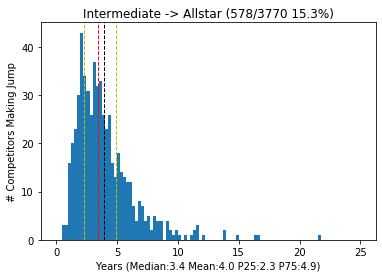

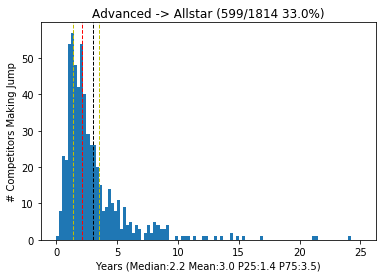

In [21]:
print('For people who reach these levels:\n')
def diff_inds(key, i, j):
    return (data[key][divs[j]] - data[key][divs[i]]).days / 365
top = len(divs)-1 # Ignore champs for now. They have too many different comp types.
for i in range(1, top):
    for j in range(i+1, top):
        s_str = keys_map_basic[divs[i]]
        t_str = keys_map_basic[divs[j]]
        valids = [diff_inds(key, i, j) for key in keys if diff_inds(key, i, j) < 50 and diff_inds(key, i, j) > 0]
        avg = np.mean(valids)
        med = np.median(valids)
        p25 = np.percentile(valids, 25)
        p75 = np.percentile(valids, 75)
        percent = (100 * len(valids)/(0.0001+count_with_points[divs[i]]))
        plt.figure()
        plt.title(f'{s_str} -> {t_str} ({len(valids)}/{count_with_points[divs[i]]} {percent:.1f}%)')
        plt.hist(valids, 100, range=(0, 25))
        plt.axvline(avg, color='k', linestyle='dashed', linewidth=1)
        plt.axvline(med, color='r', linestyle='dashed', linewidth=1)
        plt.axvline(p25, color='y', linestyle='dashed', linewidth=1)
        plt.axvline(p75, color='y', linestyle='dashed', linewidth=1)
        plt.xlabel(f'Years (Median:{med:.1f} Mean:{avg:.1f} P25:{p25:.1f} P75:{p75:.1f})')
        plt.ylabel('# Competitors Making Jump')

In [15]:
print('Fastest Growing Competitors')
sorted_competitors = sorted(keys, key=lambda k: (data[k]['ALS'] - data[k]['first_comp']).days)
top = 10
for i, k in enumerate(sorted_competitors[0:top]):
    new_to_als = (data[k]['ALS'] - data[k]['first_comp']).days / 365
    f_c = data[k]['first_comp']
    print_competitor(data[k])
    print(f'\t{i+1}) {new_to_als:.2f} {f_c}')

Fastest Growing Competitors
(7447) Jason Bryan
	1) 0.42 2010-03-01 00:00:00
(8146) Jesse Vos
	2) 0.67 2011-03-01 00:00:00
(3138) Melissa Rutz
	3) 1.00 2002-01-01 00:00:00
(3697) Will Carlton
	4) 1.16 2003-02-01 00:00:00
(9069) Lindsey Nastos
	5) 1.25 2012-04-01 00:00:00
(4904) Xavier Young
	6) 1.34 2005-07-01 00:00:00
(11908) Hailee Vaughan Hargis
	7) 1.42 2014-09-01 00:00:00
(14091) Mia Primavera
	8) 1.42 2016-04-01 00:00:00
(15300) Deon Harrell
	9) 1.50 2017-01-01 00:00:00
(8814) Stacy Kay
	10) 1.50 2011-11-01 00:00:00


In [16]:
print('Most Recent All Stars')
sorted_competitors = filter(lambda x: not data[x]['ALS'] == max_dt, keys)
sorted_competitors = sorted(sorted_competitors, key=lambda k: (datetime.datetime.now() - data[k]['ALS']).days)
top = 10
for i, k in enumerate(sorted_competitors[0:top]):
    new_to_als = (data[k]['ALS'] - data[k]['first_comp']).days / 365
    f_c = data[k]['first_comp']
    als = data[k]['ALS']
    print_competitor(data[k])
    print(f'\t{i+1}) {new_to_als:.2f} FC: {f_c} ALS: {als}')

Most Recent All Stars
(9397) David Clavilier 
	1) 7.51 FC: 2012-08-01 00:00:00 ALS: 2020-02-01 00:00:00
(11199) Anna DmiTRieva
	2) 5.93 FC: 2014-03-01 00:00:00 ALS: 2020-02-01 00:00:00
(14837) Tom-Elbin Bendheim
	3) 3.42 FC: 2016-09-01 00:00:00 ALS: 2020-02-01 00:00:00
(15296) Kathleen Sun
	4) 3.08 FC: 2017-01-01 00:00:00 ALS: 2020-02-01 00:00:00
(16096) Elizabeth Ferreira
	5) 2.59 FC: 2017-07-01 00:00:00 ALS: 2020-02-01 00:00:00
(16097) Laurel Walker
	6) 2.59 FC: 2017-07-01 00:00:00 ALS: 2020-02-01 00:00:00
(10941) Trine Nordkvelle
	7) 6.00 FC: 2014-01-01 00:00:00 ALS: 2020-01-01 00:00:00
(12203) Annika Valimaa
	8) 5.25 FC: 2014-10-01 00:00:00 ALS: 2020-01-01 00:00:00
(14563) Leo Lorenzo
	9) 3.67 FC: 2016-05-01 00:00:00 ALS: 2020-01-01 00:00:00
(15201) Jula Palenga
	10) 3.08 FC: 2016-12-01 00:00:00 ALS: 2020-01-01 00:00:00


Time From Newcomer to Novice Statistics
Reached at Least Novice       :  Med: -32082  P25: -34578 P75: -30590
Reached at Least Intermediate :  Med: -32356  P25: -34667 P75: -31107
Reached at Least Advanced     :  Med: -33040  P25: -35613 P75: -31686
Reached at Least Allstar      :  Med: -32994  P25: -34912 P75: -31929


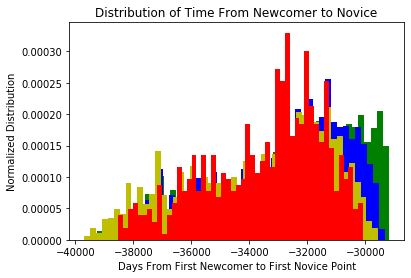

In [17]:
plt.title(f'Distribution of Time From Newcomer to Novice')
plt.xlabel(f'Days From First Newcomer to First Novice Point')
plt.ylabel('Normalized Distribution')

min_pct = 25
max_pct = 75

stats_divs = ['NOV', 'INT', 'ADV', 'ALS']
colors = ['g', 'b', 'y', 'r']

print('Time From Newcomer to Novice Statistics')
for div, color in zip(stats_divs, colors):
    people = [x for x in keys if not data[x][div] == max_dt and not data[x]['NOV'] == max_dt]
    counts = [(data[x]['NOV'] - data[x]['NEW']).days for x in people]
    med = np.median(counts)
    pmin = np.percentile(counts, min_pct)
    pmax = np.percentile(counts, max_pct)
    hist = plt.hist(counts, color=color, bins=50, density=True)
    namestr = keys_map_basic[div].ljust(13, ' ')
    med_str  = str(int(med)).rjust( 4, ' ')
    pmin_str = str(int(pmin)).rjust(4, ' ')
    pmax_str = str(int(pmax)).rjust(4, ' ')
    print(f'Reached at Least {namestr}:  Med: {med_str}  P{str(min_pct)}: {pmin_str} P{str(max_pct)}: {pmax_str}')

In [403]:
from sklearn.ensemble import RandomForestClassifier
scores = []
for random_state in range(5):
    X_delta = [(data[x]['NOV'] - data[x]['NEW']).days for x in keys if not data[x]['NOV'] == max_dt]
    X_new_points = [(data[x]['placements']['West Coast Swing']['NEW']['total_points']) for x in keys if not data[x]['NOV'] == max_dt]
    X = np.vstack((X_delta, X_new_points)).transpose()
    y = [not data[x]['ALS'] == max_dt for x in keys if not data[x]['NOV'] == max_dt]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=random_state)
    clf = 
    #clf = RandomForestClassifier(n_estimators=10, max_depth=4, min_samples_leaf=200, class_weight='balanced_subsample', random_state=random_state)
    clf.fit(X_train, y_train)
    preds = (clf.predict(X_test))
    score = clf.score(X_test, y_test) * 100 
    scores.append(score)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
print(f'Mean Classifier Accuracy: {mean_acc:.1f}%')
print(f'TP: {tp} FP: {fp} TN: {tn} FN: {fn}')
print(f'TP/(TP+FN): {tp/(tp+fn):.2f}')
print(f'TN/(TN+FP): {tn/(tn+fp):.2f}')
print(f'FN/(TP+FN): {fn/(tp+fn):.2f}')
print(f'FP/(TN+FP): {fp/(tn+fp):.2f}')
print(f'TP/(TP+FP): {tp/(tp+fp):.2f}')
print(f'FP/(TP+FP): {fp/(tp+fp):.2f}')
print(f'FN/(TP+FN): {fn/(tp+fn):.2f}')

Mean Classifier Accuracy: 70.1%
TP: 35 FP: 401 TN: 540 FN: 11
TP/(TP+FN): 0.76
TN/(TN+FP): 0.57
FN/(TP+FN): 0.24
FP/(TN+FP): 0.43
TP/(TP+FP): 0.08
FP/(TP+FP): 0.92
FN/(TP+FN): 0.24


In [417]:
pid = '12981'
person = data[pid]
name = person['dancer']['first_name'] + ' '+ person['dancer']['last_name']
X_person = [[(person['NOV'] - person['NEW']).days, person['placements']['West Coast Swing']['NEW']['total_points']]]
if not clf.predict(X_person)[0]:
    yn = 'Yes!'
else:
    yn = 'No :('
print(f'Will {name} make All Star? {yn}')

Will Tristan Tariao-Lee make All Star? No :(


In [430]:
for random_state in range(1):
    X_delta = [(data[x]['NOV'] - data[x]['NEW']).days for x in keys if not data[x]['NOV'] == max_dt and not data[x]['ALS'] == max_dt]
    X_new_points = [(data[x]['placements']['West Coast Swing']['NEW']['total_points']) for x in keys if not data[x]['NOV'] == max_dt and not data[x]['ALS'] == max_dt]
    X = np.vstack((X_delta, X_new_points)).transpose()
    y = [(data[x]['ALS'] - data[x]['NEW']).days for x in keys if not data[x]['NOV'] == max_dt and not data[x]['ALS'] == max_dt]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=random_state)
    clf = SVR()
    clf.fit(X_train, y_train)
    preds = (clf.predict(X_test))
    score = clf.score(X_test, y_test) * 100 
    print(score)

-2.2812968012501322


/home/epaper/anaconda3/envs/ipas/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [446]:
from datetime import timedelta
pid = '11650'
person = data[pid]
name = person['dancer']['first_name'] + ' '+ person['dancer']['last_name']
X_person = [[(person['NOV'] - person['NEW']).days, person['placements']['West Coast Swing']['NEW']['total_points']]]
day = person['first_comp'] + timedelta(days=clf.predict(X_person)[0])
print(f'When will {name} make All Star? {day}')

When will Michael Medini make All Star? 2019-02-28 20:39:03.868788


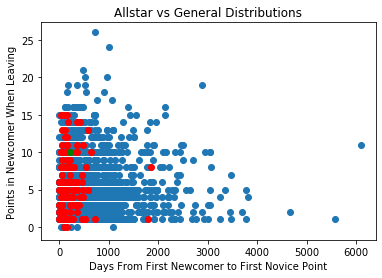

In [418]:
plt.figure()
plt.title('Allstar vs General Distributions')
plt.xlabel('Days From First Newcomer to First Novice Point')
plt.ylabel('Points in Newcomer When Leaving')
X_x = X[:,0]
X_y = X[:,1]
nov_X_x = [x for i, x in enumerate(X_x) if not y[i]]
nov_X_y = [x for i, x in enumerate(X_y) if not y[i]]
plt.scatter(nov_X_x, nov_X_y)
als_X_x = [x for i, x in enumerate(X_x) if y[i]]
als_X_y = [x for i, x in enumerate(X_y) if y[i]]
plt.scatter(als_X_x, als_X_y, color='red')
if person:
    plt.scatter([X_person[0][0]], [X_person[0][1]], color='g')